In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Rosbank ML Competition

Ссылка на соревнование: https://boosters.pro/champ_15

Росбанк – часть ведущей международной финансовой группы Societe Generale, банк включен ЦБ РФ в число 11 системно значимых кредитных организаций России. Инновации неотъемлемый процесс работы Росбанка, поэтому активно развивается направленный анализа больших данных.

- Данные

Датасет, который содержит историю транзакций клиентов за 3 месяца льготного использования банковского продукта

- Задача

Задача бинарной классификации – прогноз оттока клиентов

Колонка cl_id содержит вутренний id клиента. Для каждого уникальнго cl_id следует предсказать продолжит ли клиент пользоваться продуктом (target_flag). Значение 0 соответствует отказу, а значение 1 соответствует продолжению использования

In [2]:
raw_df = pd.read_csv('rosbank_train.csv')
raw_df.head(5)
# target_sum - можно выкинуть, переменная участвует в другой задаче
raw_df['istest'] = 0

In [3]:
test = pd.read_csv('rosbank_test.csv')
test['istest'] = 1

In [4]:
raw_df = pd.concat([raw_df,test])

In [5]:
raw_df.currency.nunique()

67

In [6]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1008889 entries, 0 to 518375
Data columns (total 11 columns):
MCC             1008889 non-null int64
PERIOD          1008889 non-null object
TRDATETIME      1008889 non-null object
amount          1008889 non-null float64
channel_type    1003825 non-null object
cl_id           1008889 non-null int64
currency        1008889 non-null int64
istest          1008889 non-null int64
target_flag     490513 non-null float64
target_sum      490513 non-null float64
trx_category    1008889 non-null object
dtypes: float64(3), int64(4), object(4)
memory usage: 92.4+ MB


In [7]:
raw_df.channel_type.value_counts(dropna=False)

type1    619756
type2    357071
type5      9668
type4      9485
type3      7845
NaN        5064
Name: channel_type, dtype: int64

In [8]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  10217


Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

## Домашняя работа

1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
3. При агрегации (*pandas.DataFrame.groupby*) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

    - общая сумма транзакций по каждой из trx_category
    - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
    - общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
    - возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
3. **Обязательная часть**: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
4. **Обязательная часть**: на большом количестве фичей применить Lasso регрессию и посмотреть, какие переменные получают 0 в качестве коэффициентов
5. **Обязательная часть**: на фичах из MCC кодов применить PCA и посмотреть, какие фичи получаются и что они могут объяснять (для этого посмотреть на коэффициенты в *sklearn.decomposition.pca.components_* после построения главных компонент)
6. **Обязательная часть**: с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. Сравнить качество модели до добавления компонент/после добавления/только на главных компонентах. **Метрика оценки качества - ROC AUC**(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
8. **Дополнительная часть**: поучаствовать в соревновании - загрузить предсказания на https://boosters.pro/champ_15. Для этого необходимо использовать все данные из файла rosbank_train.csv, на них делать feature engineering и обучениеб затем делать предсказания для клиентов из файла rosbank_test.csv, предварительно создав фичи по аналогии с train.
9. Задания принимаются в виде ноутбука с кодом/картинками выполненной обязательной части + указанием места в leaderboard при решении дополнительной

При возникновении вопросов и для отправки домашнего задания - egsachko@gmail.com или http://fb.com/sachkoe
    

In [9]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [10]:
from datetime import datetime, date, time
'''Create new col with Date (or DateTime) format'''

# Creating separate cols for yr, month,...
raw_df['Year'] = raw_df.TRDATETIME.str[5:7]
raw_df['Month'] = raw_df.TRDATETIME.str[2:5]
raw_df['Date'] = raw_df.TRDATETIME.str[0:2]
raw_df['Hour'] = raw_df.TRDATETIME.str[8:10]

# Replace month with ints
raw_df.Month = raw_df.Month.replace(to_replace=['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN',
                                                'JUL','AUG','SEP','OCT','NOV','DEC' ], 
                                    value=[1,2,3,4,5,6,7,8,9,10,11,12])
# Convert to ints (add 2000 to yr)
raw_df.Year = raw_df.Year.apply(pd.to_numeric)
raw_df.Date = raw_df.Date.apply(pd.to_numeric)
raw_df.Hour = raw_df.Hour.apply(pd.to_numeric)
raw_df.Year = raw_df.Year + 2000

In [20]:
# Add function to convert to DateTime and apply it
def to_date(row):    
    return date(row['Year'],row['Month'],row['Date'])
raw_df['DateFormat'] = raw_df.apply(to_date, axis=1)

In [21]:
raw_df['channel_type'].fillna('type10', inplace = True)

In [22]:
raw_df.head()

,MCC,PERIOD,TRDATETIME,amount,channel_type,cl_id,currency,istest,target_flag,target_sum,trx_category,Year,Month,Date,Hour,DateFormat
0,5200,01/10/2017,21OCT17:00:00:00,5023.0,type10,0,810,0,0.0,0.0,POS,2017,10,21,0,2017-10-21
1,6011,01/10/2017,12OCT17:12:24:07,20000.0,type10,0,810,0,0.0,0.0,DEPOSIT,2017,10,12,12,2017-10-12
2,5921,01/12/2017,05DEC17:00:00:00,767.0,type10,0,810,0,0.0,0.0,POS,2017,12,5,0,2017-12-05
3,5411,01/10/2017,21OCT17:00:00:00,2031.0,type10,0,810,0,0.0,0.0,POS,2017,10,21,0,2017-10-21
4,6012,01/10/2017,24OCT17:13:14:24,36562.0,type10,0,810,0,0.0,0.0,C2C_OUT,2017,10,24,13,2017-10-24


In [23]:
'''Create columns with MCC general groups (20) and MCC groups (338)'''

# Extract data from excel
codes = pd.read_excel('mcc_codes.xlsx')

# Merge dataframes with mutual insex 'MCC'
merged = raw_df.merge(codes, left_on='MCC',right_on='чисоло',how = 'left')
merged.drop('чисоло',axis = 1, inplace = True)

# Fill NaN values (manually)
merged['Имя'].fillna('Отели, мотели, курорты', inplace = True)
merged['Группа'].fillna('Отели и мотели', inplace = True)

In [24]:
# raw_df.groupby(['cl_id','channel_type','target_flag','MCC','currency']).agg({'amount':'sum', 'DateFormat':'min'})

In [25]:
'''Add columns with converted amount values'''

curr = pd.read_excel('curr.xlsx')
merg_curr = merged.merge(curr, left_on='currency',right_on='Code_int',how = 'left')
merg_curr.drop(['Code','Code_int'],axis = 1, inplace = True)

def to_curr(row):
    return row['amount']*row['Curr']

merg_curr['amount_conv'] = merg_curr.apply(to_curr, axis = 1)

In [31]:
# merg_curr[merg_curr['Code_int'].isnull() == True]['currency'].unique()

In [32]:
# Средняя дата операций
# date.fromordinal(int(merged['DateFormat'].apply(lambda x: x.toordinal()).mean()))

In [33]:
merg_curr.to_csv('amounts_conv')

In [34]:
w_df = merg_curr.copy()

In [35]:
# w_df.drop(['PERIOD', 'TRDATETIME','amount','Year','Month','Date','Имя','Curr'],axis=1,inplace=True)

In [36]:
'''Calculating duration of using period'''

date_df = w_df.groupby(['cl_id']).agg({'DateFormat':'min', 'target_flag':'min'})
date_df['Last'] = w_df.groupby(['cl_id']).agg({'DateFormat':'max'})['DateFormat']

def duration(row):
    return row[2].toordinal() - row[0].toordinal()

date_df['Duration'] = date_df.apply(duration, axis = 1)

In [37]:
'''Если удалять операции по снятию наличнки, то количество людей, пользующихся продуктом
более 3 месяцев уменьшается (с 300 до 77 или 35, если применить еще и 6012)'''
# w_df = w_df.drop(np.where(w_df['MCC'] == 6011)[0])
# w_df = w_df.query("MCC != 6011")
# w_df = w_df.query("MCC != 6012")

# date_df.Duration.max()
# date_df[date_df.Duration > 95].target_flag.sum(), date_df[date_df.Duration > 95].shape
# date_df[(date_df.Duration > 100) & (date_df.target_flag ==0)].head()

'Если удалять операции по снятию наличнки, то количество людей, пользующихся продуктом\nболее 3 месяцев уменьшается (с 300 до 77 или 35, если применить еще и 6012)'

In [ ]:
w_df.head()

In [38]:
'''Creating my_table
Adding duration, amount sum'''

my_table = date_df.copy()
my_table.drop(['DateFormat','Last'],axis = 1, inplace = True)
temp = w_df.groupby('cl_id').agg({'amount_conv':'sum','amount':'sum'})
my_table['amount_sum'] = temp['amount_conv']

In [39]:
'''Adding columns presents separate MCC and separate operation types'''

from pandas import pivot_table

table = pivot_table(w_df, values = 'amount_conv',
                   index = ['cl_id'],columns = 'trx_category', aggfunc=np.sum)
table1 = pivot_table(w_df, values = 'amount_conv',
                   index = ['cl_id'],columns = 'Группа', aggfunc=np.sum)
table.fillna(0,inplace=True)
table1.fillna(0,inplace=True)
my_table = my_table.join(table)
my_table = my_table.join(table1)

In [40]:
table2 = pivot_table(w_df, values = 'amount_conv',
                   index = ['cl_id'],columns = 'MCC', aggfunc=len)

In [41]:
table2.fillna(0,inplace=True)

Text(0,0.5,'explained_variance_ratio_')

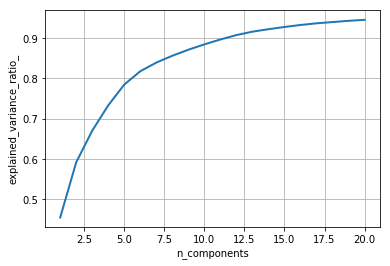

In [42]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20).fit(table2)

cum_evr = np.cumsum(pca.explained_variance_ratio_)
xs = np.arange(cum_evr.size)+1
plt.plot(xs, cum_evr, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

In [43]:
cols2 = table2.columns
table3 = pca.transform(table2)
colsPCA = []
for i in range(20):
    colsPCA.append('PCA' + str(i))

In [44]:
table4 = pd.DataFrame(table3, columns=colsPCA)

In [45]:
my_table = my_table.join(table4.set_index(my_table.index))

In [75]:
X_te = my_table[my_table.target_flag.isna() == True]

X_tr = my_table[my_table.target_flag.isna() == False]

Y_tr = X_tr['target_flag']

X_tr = X_tr.drop('target_flag',axis=1)

X_te = X_te.drop('target_flag',axis=1)

Тестовое предсказание

In [78]:
Xtr,Xte,Ytr,Yte = train_test_split(X_tr,Y_tr,test_size=0.2)
params = {'n_estimators': 1000,
          'learning_rate': 0.01,
          'max_depth': 7,
          'min_child_weight': 10,
          'subsample': 0.6,
          'colsample_bytree': 0.7,
          'n_jobs': 4,
         }
model = xgb.XGBClassifier(**params)
model.fit(Xtr,Ytr)
model.score(Xte,Yte)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.758

In [79]:
model.fit(X_tr,Y_tr)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=7, min_child_weight=10, missing=None, n_estimators=1000,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6)

In [80]:
predictions = model.predict(X_te)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [81]:
predictions

array([1., 1., 1., ..., 1., 0., 1.])

In [87]:
for_sub = test.drop_duplicates('cl_id').copy()
df_pred = pd.DataFrame(for_sub.cl_id, columns = ['cl_id'])
df_pred['target_flag'] = predictions
df_pred = df_pred.set_index('cl_id')
df_pred.to_csv('submission.csv')